In [95]:
import pandas as pd
import fiona
import seaborn
# import geopandas as gp
# from geopandas import GeoDataFrame
# from shapely.geometry import Point
import numpy as np
import statsmodels.api as sm
import matplotlib
import matplotlib.pylab as pl
from pylab import rcParams
import matplotlib.pyplot as plt

import csv

from datetime import datetime
from dateutil.parser import parse

%matplotlib inline

# 1. Importing 311 data and selecting relevant subset

Previously filtered for complaints under Department of Health and Mental Hygiene from January 1, 2016 through December 31, 2016.

In [47]:
data = pd.read_csv('311_Service_Requests_DOHMH_2016.csv')
data.columns
len(data)

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


66591

In [48]:
data.drop(['Agency','Agency Name', 'Street Name', 'Address Type',
       'City', 'Landmark', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Park Facility Name', 'Park Borough',
       'School Name', 'School Number', 'School Region', 'School Code',
       'School Phone Number', 'School Address', 'School City', 'School State',
       'School Zip', 'School Not Found', 'School or Citywide Complaint',
       'Vehicle Type', 'Taxi Company Borough', 'Taxi Pick Up Location',
       'Bridge Highway Name', 'Bridge Highway Direction', 'Road Ramp',
       'Bridge Highway Segment', 'Garage Lot Name', 'Ferry Direction',
       'Ferry Terminal Name', 'Intersection Street 1', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 2', 'Facility Type', 'Location', 'Latitude', 'Longitude'], axis=1, inplace=True)

In [49]:
data['Location Type'].unique()

array(['Residential Building', 'Restaurant/Bar/Deli/Bakery', 'Vacant Lot',
       'Other (Explain Below)', '3+ Family Apt. Building',
       '1-2 Family Dwelling', 'Commercial Building',
       '1-2 Family Mixed Use Building', 'Apartment', 'Vacant Building',
       '3+ Family Apartment Building', 'Catch Basin/Sewer',
       '3+ Family Mixed Use Building', 'Public Garden', 'Food Cart Vendor',
       'Building (Non-Residential)', 'Pet Shop', 'Construction Site',
       'Residence', 'Parking Lot/Garage', 'Steam Room',
       'Single Room Occupancy (SRO)', 'Public/Unfenced Area',
       'Cafeteria - Private', 'Senior Center', 'Pool', 'Public Stairs',
       'Spa Pool', 'Other', 'Restaurant', '1-3 Family Dwelling', 'Groomer',
       'Tattoo Parlor', 'School/Pre-School', 'Office Building',
       'Government Building', 'Hospital', 'School', 'Private School',
       'Private House', 'Day Care/Nursery', 'Cafeteria - Private School',
       'Soup Kitchen', 'Public School', 'Nursing Home',
     

In [50]:
residential = ('Residential Building', '3+ Family Apt. Building', '1-2 Family Dwelling', 
                                     '1-2 Family Mixed Use Building', 'Apartment',  '3+ Family Apartment Building',
                                     '3+ Family Mixed Use Building', 'Residence', 'Single Room Occupancy (SRO)',
                                     '1-3 Family Dwelling', 'Residential Property', '1-3 Family Mixed Use Building',)
data = data.loc[data['Location Type'].isin(residential)]
len(data)

35943

After selecting for only residential buildings, the number of complaints is reduced from 66,591 to 35,943.

In [51]:
data.head()

,Unique Key,Created Date,Closed Date,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address
0,32306500,01/01/2016 12:32:21 AM,NaN,Smoking,Smoking Violation,Residential Building,10468.0,2337 GRAND CONCOURSE
4,32310788,01/01/2016 12:00:00 AM,11/23/2015 12:00:00 AM,Rodent,Mouse Sighting,3+ Family Apt. Building,10029.0,2172 2ND AVENUE
5,32310789,01/01/2016 12:00:00 AM,NaN,Rodent,Mouse Sighting,3+ Family Apt. Building,11432.0,159-44 NORMAL ROAD
6,32310790,01/01/2016 12:00:00 AM,01/20/2016 12:00:00 AM,Rodent,Mouse Sighting,3+ Family Apt. Building,11210.0,2300 KINGS HIGHWAY
7,32310791,01/01/2016 12:00:00 AM,11/23/2015 12:00:00 AM,Rodent,Mouse Sighting,3+ Family Apt. Building,10029.0,2172 2ND AVENUE


In [52]:
data['Descriptor'].unique()

array(['Smoking Violation', 'Mouse Sighting', 'Dog', 'Rat Sighting',
       'Signs of Rodents', 'Unlicensed Day Care',
       'Chemical Vapors/Gases/Odors', 'Sewage Odor',
       'Condition Attracting Rodents', 'Other', 'Cat',
       'Other (Explain Below)', 'Ventilation', 'Pigeon Waste',
       'Farm Animal', 'Dust from Construction',
       'Illness Caused by Drinking Water', nan, 'Rooster', 'Sewage Leak',
       'Other Animal', 'Dry Cleaning Vapors (PERC)', 'Tenant Refusal',
       'Snake', 'Pigeon Odor', 'Iguana', 'Permit/License/Certificate',
       'Bees/Wasps - Not a beekeper', 'Beekeeping - Honeybees',
       'Container - Over 5 Gallons', 'Swimming Pool Cover',
       'Puddle in Ground', 'Swimming Pool - Unmaintained', 'Ferret',
       'Sewer or Drain', 'No Permit or License',
       'Container - Under 5 Gallons', 'Puddle on Sidewalk',
       'Puddle on Driveway', 'Bird Bath', 'Large Number of Mosquitoes',
       'Flower Planters', 'Monkey', 'Puddle on Roof',
       'Fountain -

In [53]:
landlord_issues = ('Smoking Violation', 'Mouse Sighting', 'Dog', 'Rat Sighting',
       'Signs of Rodents',
       'Chemical Vapors/Gases/Odors', 'Sewage Odor',
       'Condition Attracting Rodents', 'Cat', 'Ventilation', 'Pigeon Waste',
       'Farm Animal', 'Dust from Construction',
       'Illness Caused by Drinking Water', 'Rooster', 'Sewage Leak',
       'Other Animal', 'Dry Cleaning Vapors (PERC)', 'Tenant Refusal',
       'Snake', 'Pigeon Odor', 'Iguana',
       'Puddle in Ground', 'Ferret',
       'Sewer or Drain',
       'Puddle on Driveway', 'Large Number of Mosquitoes',
       'Flower Planters', 'Monkey', 'Puddle on Roof',
       'Basement',
       'Turtle Under 4 inches Long', 'Tires',
       'Roof Gutters')
data = data.loc[data['Descriptor'].isin(landlord_issues)]
len(data)

32605

After selecting for only things that endanger tenants or affect their quality of life and that landlords can control, the number of complaints is reduced from 35,943 to 32,605.

# 2. Counting the number of complaints of each type

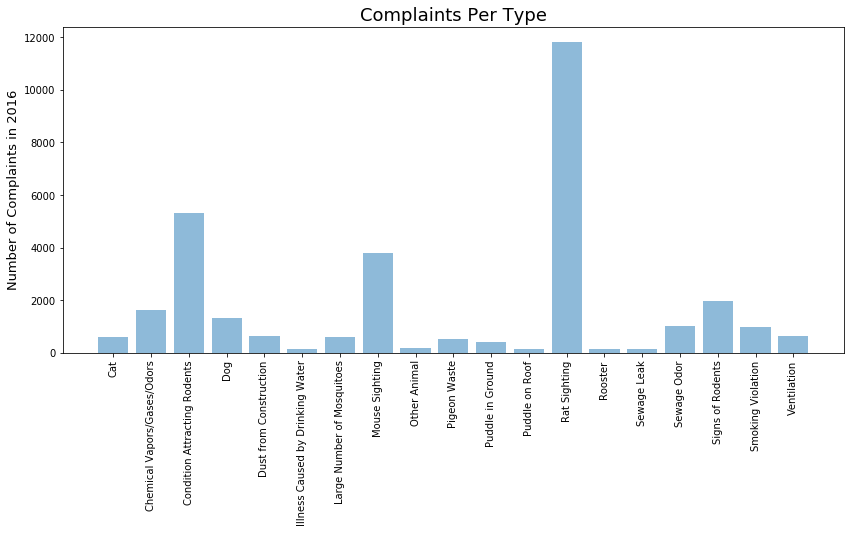

In [84]:
def plot_complaints_per_type(df):
    complaint1 = df.groupby('Descriptor')
    complaint = pd.DataFrame(complaint1['Descriptor'].apply(np.size))
    complaint.rename(columns = {'Descriptor':'Number_of_Calls'}, inplace = True)
    # next line eliminates complaint types with very few complaints
    complaint = complaint[complaint['Number_of_Calls'] > (np.max(complaint['Number_of_Calls'])/100)]
    complaint['Complaint_Type'] = complaint.index
    
    objects = complaint['Complaint_Type']
    y_pos = np.arange(len(objects))
    number = complaint['Number_of_Calls']

    plt.figure(figsize=(14,6))
    plt.bar(y_pos, number, align='center', alpha=0.5)
    plt.xticks(y_pos, objects, rotation='vertical')
    plt.ylabel('Number of Complaints in 2016', fontsize=13)
    plt.title('Complaints Per Type', fontsize=18)
    
plot_complaints_per_type(data)

# 3. Counting total complaints per zip code

In [146]:
zips1 = data.groupby('Incident Zip')
zips = pd.DataFrame(zips1['Incident Zip'].apply(np.size))
zips.rename(columns = {'Incident Zip':'Number_of_Calls'}, inplace = True)
zips.sort_values(by='Number_of_Calls', axis=0, ascending=False, inplace=True)
zips.index.name = None
zips['zip'] = zips.index
print('There are', len(zips), 'zip codes in the data.')
print('------------------------------')
print('These zip codes have only one call:', zips[zips['Number_of_Calls'] == 1.0])
print('------------------------------')
print(zips.head())
print('------------------------------')
zips.describe()

There are 185 zip codes in the data.
------------------------------
These zip codes have only one call:          Number_of_Calls      zip
10129.0                1  10129.0
11430.0                1  11430.0
10162.0                1  10162.0
11005.0                1  11005.0
11109.0                1  11109.0
11202.0                1  11202.0
11697.0                1  11697.0
------------------------------
         Number_of_Calls      zip
11221.0              776  11221.0
10467.0              620  10467.0
11216.0              619  11216.0
10025.0              545  10025.0
11226.0              526  11226.0
------------------------------


,Number_of_Calls,zip
count,185.000000,185.000000
mean,176.108108,10814.351351
std,146.524739,573.757780
min,1.000000,10001.000000
25%,71.000000,10301.000000
50%,138.000000,11106.000000
75%,258.000000,11360.000000
max,776.000000,11697.000000


## RECOMMENDATION: The Tenant Support Unit should start with zip code 11221

Text(0,0.5,'Number of Zip Codes')

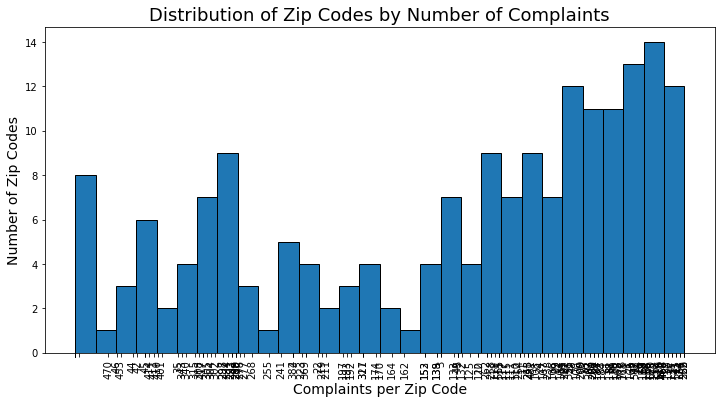

In [119]:
# labels = ['label1', 'label2', 'label3']
pl.figure(figsize=(12, 6))
pl.hist(zips, bins=30, edgecolor='black', linewidth=1)
labels = 
pl.xticks(zips['Number_of_Calls'], labels, rotation = 'vertical')
pl.title('Distribution of Zip Codes by Number of Complaints', fontsize = 18)
pl.xlabel('Complaints per Zip Code', fontsize = 14)
pl.ylabel('Number of Zip Codes', fontsize = 14)

In [ ]:
# bins = np.arange(10, 99, 5)
# ax = zips.groupby(pd.cut(zips['Number_of_Calls'], bins)).plot(kind='bar', legend=False)
# ax.set_title("Citi Bike Rider Age")

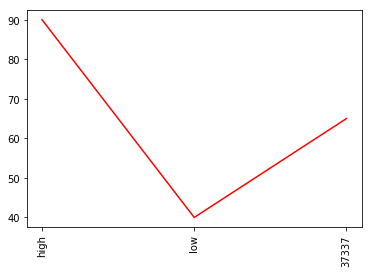

In [120]:
x = [0,1,2]
y = [90,40,65]
labels = ['high', 'low', 37337]
plt.plot(x,y, 'r')
plt.xticks(x, labels, rotation='vertical')
plt.show()

# 4. More detail on zip code 11221

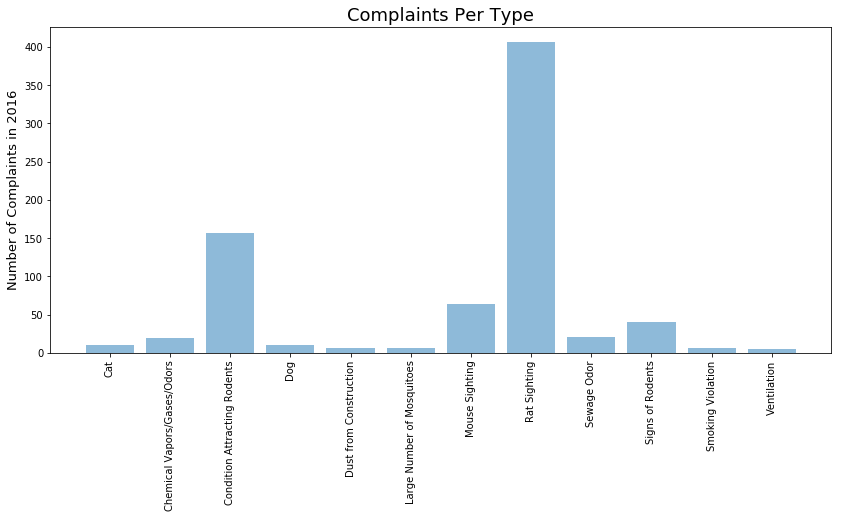

In [150]:
target = data[data['Incident Zip'] == 11221.0]
plot_complaints_per_type(target)

In [162]:
type1 = target.groupby('Descriptor')
Type = pd.DataFrame(type1['Descriptor'].apply(np.size))
Type.rename(columns = {'Descriptor':'Number_of_Calls'}, inplace = True)
Type['Complaint_Type'] = Type.index
Type.sort_values(by='Number_of_Calls', axis=0, ascending=False, inplace=True)
Type.index = np.arange(1, len(Type)+1)
Type.index.name = 'Rank'
Type.head(10)

,Number_of_Calls,Complaint_Type
Rank,,
1,406,Rat Sighting
2,157,Condition Attracting Rodents
3,64,Mouse Sighting
4,41,Signs of Rodents
5,21,Sewage Odor
6,20,Chemical Vapors/Gases/Odors
7,11,Dog
8,11,Cat
9,7,Smoking Violation


## CITY COUNCILOR: these are the top ten tenant-related complaints in the most complained-about zip code in your district

# 5. Counting which properties have the most complaints.

# 6. Bringing in other 311 complaints (esp heat and mold related)